# Inputs

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pandas as pd
import subprocess
import os
import glob as glob

from rdkit import Chem
from rdkit.Chem import DataStructs

# shut off warnings
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')   

from rdkit.Chem import RDConfig
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer

# from crem_pipeline import calculateScoreThruToxModel, collate_crem_molecules_from_multiple_rounds, hist_plot, filter_crem_dataframe, analyze_crem_df
# from pipeline import process_molset

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-s8porhqb because the default path (/home/jackievaleri8/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Helper functions

In [52]:
# FUNCTIONS REPRODUCED FROM OTHER FILES
def calculateScoreThruToxModel(patterns, results_folder_name, results_file_name, tox_model):
    # write to clean csv
    clean_name = results_folder_name + tox_model + '_' + results_file_name
    new_df = pd.DataFrame(patterns, columns = ['SMILES'])
    new_df.to_csv(clean_name, index=False)

    # use subprocess to run command line thru jupyter notebook - could easily just run command line but this is automated
    activate_command = 'source activate chemprop; '
    if tox_model == 'primary':
        model_folder = 'final_tox_primary'
    elif tox_model == 'hepg2':
        model_folder = 'final_tox_hepg2'
    run_command = 'python predict.py --test_path ' + '../generativeML/out/' + clean_name + ' --checkpoint_dir ../generativeML/models/' + model_folder + ' --preds_path ' + '../generativeML/out/' + clean_name + ' --features_generator rdkit_2d_normalized --no_features_scaling --smiles_columns SMILES'
    full_command = activate_command + run_command
    test = subprocess.run(full_command, cwd="../../chemprop/", shell=True, capture_output=True)
    preds = pd.read_csv(clean_name)

    new_smis = list(preds['SMILES'])
    new_scores = list(preds['TOXICITY'])
    if len(new_smis) > 0:
        return([new_smis, new_scores])
    else:
        return([])
    
def process_molset(path, smi_col, hit_col = '', just_actives = False, hit_thresh = 0):
    if path == '':
        print('No data have been provided for a comparison.')
    df = pd.read_csv(path)
    if just_actives:
        df = df[df[hit_col] < hit_thresh]
        df = df.reset_index(drop=True)
    mols = [Chem.MolFromSmiles(smi) for smi in list(df[smi_col])]
    keep_indices = [m is not None for m in mols]
    df = df[keep_indices]
    mols = [m for i,m in enumerate(mols) if keep_indices[i]]
    return(df, mols)

In [53]:
# HELPER FUNCTIONS
def collate_crem_molecules_from_multiple_rounds(results_path, out_dir, smi_col = 'SMILES', hit_col = 'ACTIVITY'):
    columns = ['Score', 'Grow_or_Mut', 'Algorithm_Params', 'Round', smi_col, hit_col]
    allmolsdf = pd.DataFrame(columns = columns)
    currmolsdf = pd.DataFrame(columns = columns)
    
    for path in results_path:
        allmolsdf = pd.concat([allmolsdf, currmolsdf])
        currmolsdf = pd.DataFrame(columns = columns)
        
        for filename in glob.glob(out_dir + path + '/*/*_scores.csv'):
            # find out if directed or naive score
            if 'modified_score' in filename:
                method = 'modified_score'
            else:
                method = 'chemprop_score'

            # get grow or mutate
            if 'grow' in filename:
                mod = 'grow'
            elif 'mutate' in filename:
                mod = 'mutate'

            # get parameters and round
            param_names = filename.split(mod + '/')[1].split('/')[0]
            rd = filename.split('all_mols_round_')[1].split('_scores.csv')[0]

            df = pd.read_csv(filename)
            try:
                act = df[df[hit_col] > 0.1] # some did not make it to have their activities calculated - exclude
            except:
                continue
            df['Score'] = [method] * len(df)
            df['Grow_or_Mut'] = [mod] * len(df)
            df['Algorithm_Params'] = [param_names] * len(df)
            df['Round'] = ['Round ' + str(rd)] * len(df)
            currmolsdf = pd.concat([currmolsdf, df])
    allmolsdf = pd.concat([allmolsdf, currmolsdf])
    return(allmolsdf)
    
def hist_plot(data, xs, xlabel, hue = 'Round'):
    # gate on score from model
    fig = plt.figure(figsize = (3,3), dpi = 300)
    sns.histplot(data = data, x = xs, hue = hue)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

def filter_crem_dataframe(allmolsdf, smi_col, hit_col, hit_thresh = 0.5, sascore_thresh = 3, tan_to_abx = 0.5, abx_path = '', abx_smiles_col = 'SMILES', hepg2_tox_thresh = 0.2, prim_tox_thresh = 0.2, tan_to_train_set = 0.5, train_set_path = '', train_set_smiles_col = 'SMILES', train_set_hit_col = '', train_set_just_actives = False, train_set_hit_thresh = 0, patterns = [], orig_mol_tan_thresh = 1.0, orig_mol = None, display = True):
    # deduplicate
    print('original length: ', len(allmolsdf))
    df = allmolsdf.drop_duplicates(smi_col)
    df = df.reset_index(drop=True)
    print('deduplicated on smiles: ', len(df))
    
    # gate on score:
    if display:
        hist_plot(df, hit_col, 'Chemprop Score', 'Round')
    df = df[df[hit_col] > hit_thresh]
    print('scores > ' + str(hit_thresh) + ': ', len(df))

    # gate on synthesizability
    mols = [Chem.MolFromSmiles(smi) for smi in list(df[smi_col])]
    df['sa_score'] = [sascorer.calculateScore(mol) for mol in mols]
    if display:
        hist_plot(df, 'sa_score', 'Synthetic Complexity', 'Round')
    keep_indices = [sascore < sascore_thresh for sascore in list(df['sa_score'])]
    df = df[keep_indices].reset_index(drop=True)
    print('SAScore < ' + str(sascore_thresh) + ': ', len(df))

    # gate on tanimoto similarity to abx
    abx, abx_mols = process_molset(abx_path, abx_smiles_col)
    abx_fps = [Chem.RDKFingerprint(mol) for mol in abx_mols]
    mols = [Chem.MolFromSmiles(smi) for smi in list(df[smi_col])]
    query_fps = [Chem.RDKFingerprint(mol) for mol in mols]
    df['max_tan_sim_to_abx'] = [max(DataStructs.BulkTanimotoSimilarity(query_fp, abx_fps)) for query_fp in query_fps]
    if display:
        hist_plot(df, 'max_tan_sim_to_abx', 'Max Tan Sim to Known Antibiotics', 'Round')
    keep_indices = [max_tan < tan_to_abx for max_tan in list(df['max_tan_sim_to_abx'])]
    df = df[keep_indices].reset_index(drop=True)
    mols = [m for i,m in enumerate(mols) if keep_indices[i]]
    print('Tan Sim to Abx < ' + str(tan_to_abx) + ': ', len(df))

    # gate on toxicity scores
    _, hepg2_toxs = calculateScoreThruToxModel(list(df[smi_col]), OUT_DIR, '_temp_predictions.csv', 'hepg2')
    df['hepg2_pred_tox'] = hepg2_toxs
    if display:
        hist_plot(df, 'hepg2_pred_tox', 'HepG2 Tox Model Score', 'Round')
    keep_indices = [tox < hepg2_tox_thresh for tox in list(df['hepg2_pred_tox'])]
    df = df[keep_indices].reset_index(drop=True)
    mols = [m for i,m in enumerate(mols) if keep_indices[i]]
    print('HepG2 pred tox < ' + str(hepg2_tox_thresh) + ': ', len(df))

    _, prim_toxs = calculateScoreThruToxModel(list(df[smi_col]), OUT_DIR, '_temp_predictions.csv', 'primary')
    df['primary_pred_tox'] = prim_toxs
    if display:
        hist_plot(df, 'primary_pred_tox', 'Primary Tox Model Score', 'Round')
    keep_indices = [tox < prim_tox_thresh for tox in list(df['primary_pred_tox'])]
    df = df[keep_indices].reset_index(drop=True)
    mols = [m for i,m in enumerate(mols) if keep_indices[i]]
    print('Primary pred tox < ' + str(prim_tox_thresh) + ': ', len(df))
    
    # gate on tanimoto similarity to train set
    ts, ts_mols = process_molset(train_set_path, train_set_smiles_col, train_set_hit_col, train_set_just_actives, train_set_hit_thresh)
    ts_fps = [Chem.RDKFingerprint(mol) for mol in ts_mols]
    query_fps = [Chem.RDKFingerprint(mol) for mol in mols]
    df['max_tan_sim_to_ts'] = [max(DataStructs.BulkTanimotoSimilarity(query_fp, ts_fps)) for query_fp in query_fps]
    if display:
        hist_plot(df, 'max_tan_sim_to_ts', 'Max Tan Sim to Train Set', 'Round')
    keep_indices = [max_tan < tan_to_train_set for max_tan in list(df['max_tan_sim_to_ts'])]
    df = df[keep_indices].reset_index(drop=True)
    mols = [m for i,m in enumerate(mols) if keep_indices[i]]
    print('Max Tan Sim to TS < ' + str(tan_to_train_set) + ': ', len(df))
    
    # exclude patterns
    if len(patterns) > 0: # patterns is list of mols
        for pattern in patterns:
            exclude_indices = []
            for i, mol in enumerate(mols):
                if mol.HasSubstructMatch(pattern):
                    exclude_indices.append(i)
        
            df = df.iloc[[i not in exclude_indices for i in range(len(df))],:]
            mols = [m for i,m in enumerate(mols) if i not in exclude_indices]
            print('excluding pattern: ', len(df))
            
    # calculate tanimoto similarity to the original molecule as well
    orig_mol_fp = Chem.RDKFingerprint(orig_mol)
    query_fps = [Chem.RDKFingerprint(mol) for mol in mols]
    df['tan_sim_to_orig_mol'] = [DataStructs.TanimotoSimilarity(query_fp, orig_mol_fp) for query_fp in query_fps]
    if display:
        hist_plot(df, 'tan_sim_to_orig_mol', 'Tanimoto Similarity to Orig Mol', 'Round')
    keep_indices = [tan < orig_mol_tan_thresh for tan in list(df['tan_sim_to_orig_mol'])]
    df = df[keep_indices].reset_index(drop=True)
    mols = [m for i,m in enumerate(mols) if keep_indices[i]]
    print('Tan sim to orig mol < ' + str(orig_mol_tan_thresh) + ': ', len(df))
    
    return(df)

# calculate how many are from each method
def analyze_crem_df(df):
    print('grow', len(df[df['Grow_or_Mut'] == 'grow']))
    print('mutate', len(df[df['Grow_or_Mut'] == 'mutate']))
    print('regular score', len(df[df['Score'] == 'chemprop_score']))
    print('modified score', len(df[df['Score'] == 'modified_score']))
    for i in range(5):
        print('round ' + str(i), len(df[df['Round'] == 'Round ' + str(i)]))

In [57]:
OUT_DIR = '../out/crem/mol9_crem/' # intermediate folder for predictions and results, will tag with grow/ or mutate/
RESULTS_PATHS = [
           'modified_score/grow', # new score
           'modified_score/mutate', # new score
           'regular_score/grow', # old score
           'regular_score/mutate' # old score
          ] 
SMI_COL = 'SMILES'
HIT_COL = 'ACTIVITY'

HIT_THRESH = 0.5
SASCORE_THRESH = 5

TAN_TO_ABX = 0.5
ABX_PATH = '../data/static_datasets/04052022_CLEANED_v5_antibiotics_across_many_classes.csv'
ABX_SMILES_COL = 'Smiles'

HEPG2_TOX_THRESH = 0.2
PRIM_TOX_THRESH = 0.2

TAN_TO_TRAIN_SET = 0.6
TRAIN_SET_PATH = '../data/training_data/SA/combined_SA_screen_39K.csv'
TRAIN_SET_SMILES_COL = 'SMILES'
TRAIN_SET_JUST_ACTIVES = False

ORIG_MOL_SMI = 'CSC1=C(F)C=C(NC(=O)N[C@H]2[C@H]3CC[C@H](O3)[C@@H]2C(F)(F)F)C=C1F'
ORIG_MOL = Chem.MolFromSmiles(ORIG_MOL_SMI)
ORIG_MOL_TAN_THRESH = 1.0

DISPLAY_IN_LINE = True

# Get all mols from each round

In [34]:
allmolsdf = collate_crem_molecules_from_multiple_rounds(RESULTS_PATHS, OUT_DIR, smi_col = SMI_COL, hit_col = HIT_COL)
allmolsdf.to_csv(OUT_DIR + 'all_crem_mol9_generated_mols.csv', index = False)
allmolsdf

,Score,Grow_or_Mut,Algorithm_Params,Round,SMILES,ACTIVITY
0,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,CSc1c(F)c(C(=O)O)c(NC(=O)N[C@@H]2[C@@H](C(F)(F...,0.610178
1,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,CSc1c(F)c(C(=O)O)c(NC(=O)N[C@@H]2[C@@H](C(F)(F...,0.589405
2,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,CSc1c(F)c(C(=O)O)c(NC(=O)N[C@@H]2[C@@H](C(F)(F...,0.592488
3,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,CSc1c(F)c(C(=O)O)c(NC(=O)N[C@@H]2[C@@H](C(F)(F...,0.583216
4,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,CSc1c(F)c(C(=O)O)c(NC(=O)N[C@@H]2[C@@H](C(F)(F...,0.588789
...,...,...,...,...,...,...
56,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,O=C(Nc1cc(F)c(SC2CCCCC2)c(F)c1)N[C@@H]1[C@@H](...,0.286672
57,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,O=C(Nc1cc(F)c(SC2=NCCN2)c(F)c1)N[C@@H]1[C@@H](...,0.331590
58,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,O=C1CC(Sc2c(F)cc(NC(=O)N[C@@H]3[C@@H](C(F)(F)F...,0.470763
59,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,O=C(Nc1cc(F)c(SCCO)c(F)c1)N[C@@H]1[C@@H](C(F)(...,0.382627


original length:  342630
deduplicated on smiles:  278202


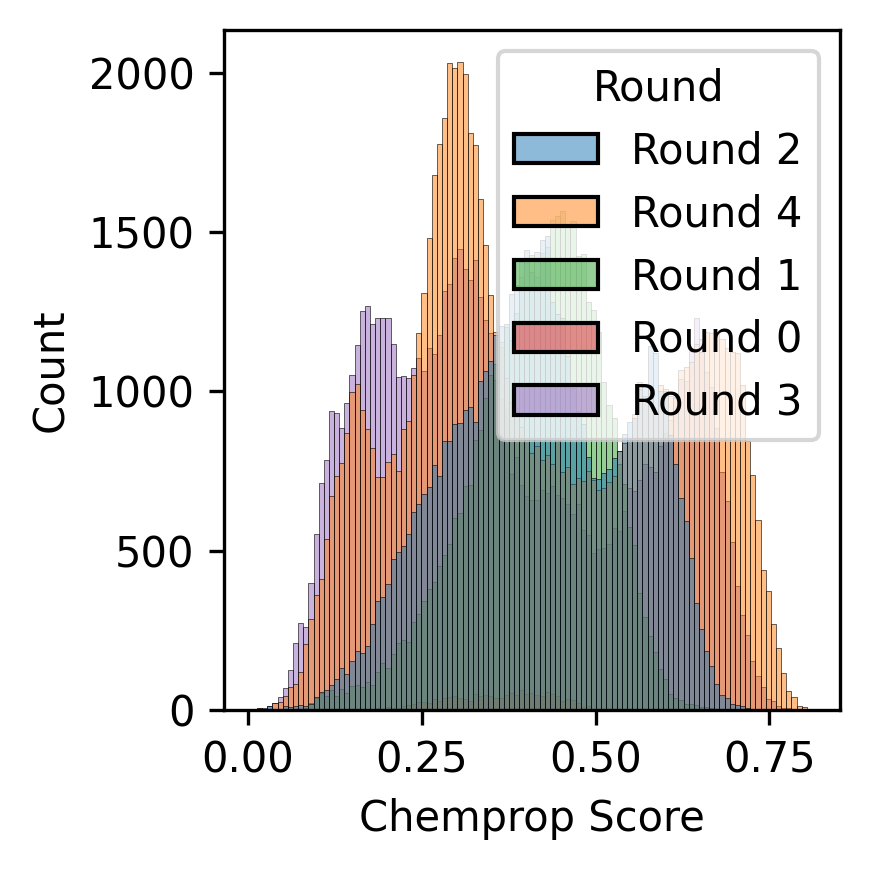

scores > 0.5:  81505


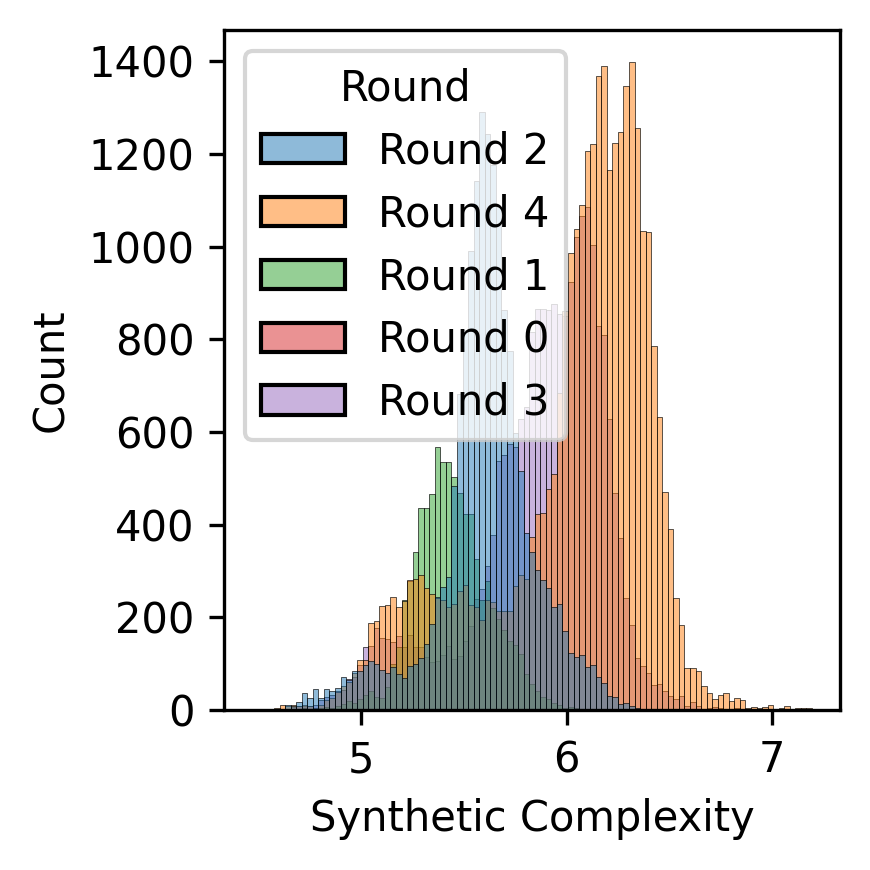

SAScore < 5:  1591


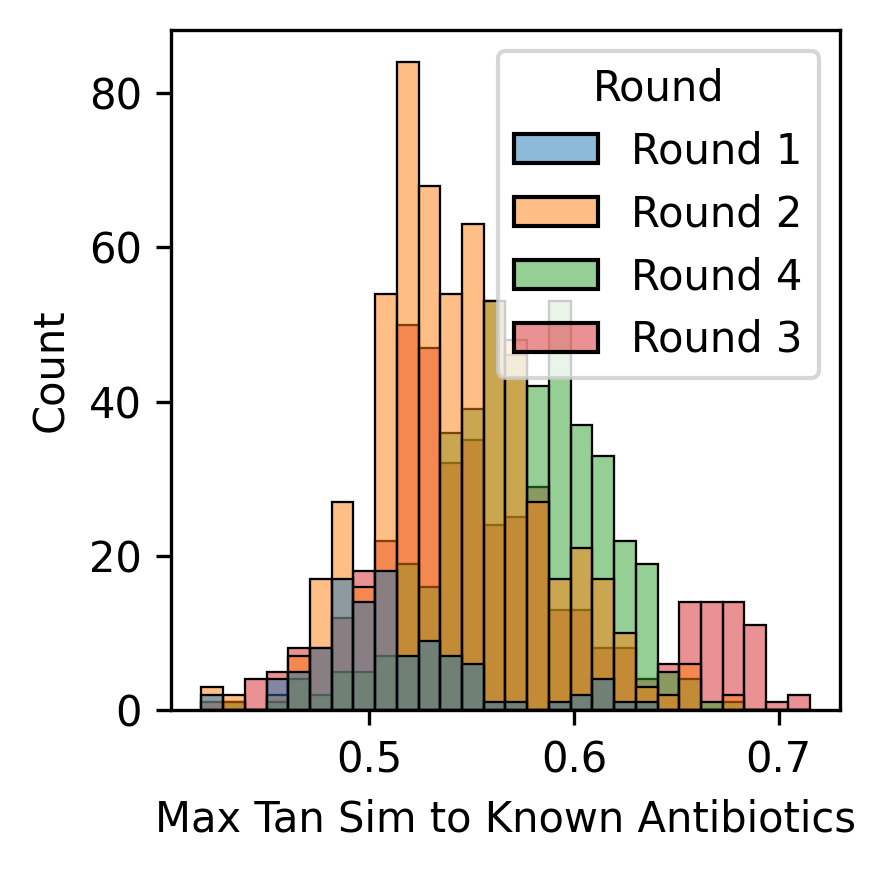

Tan Sim to Abx < 0.5:  187


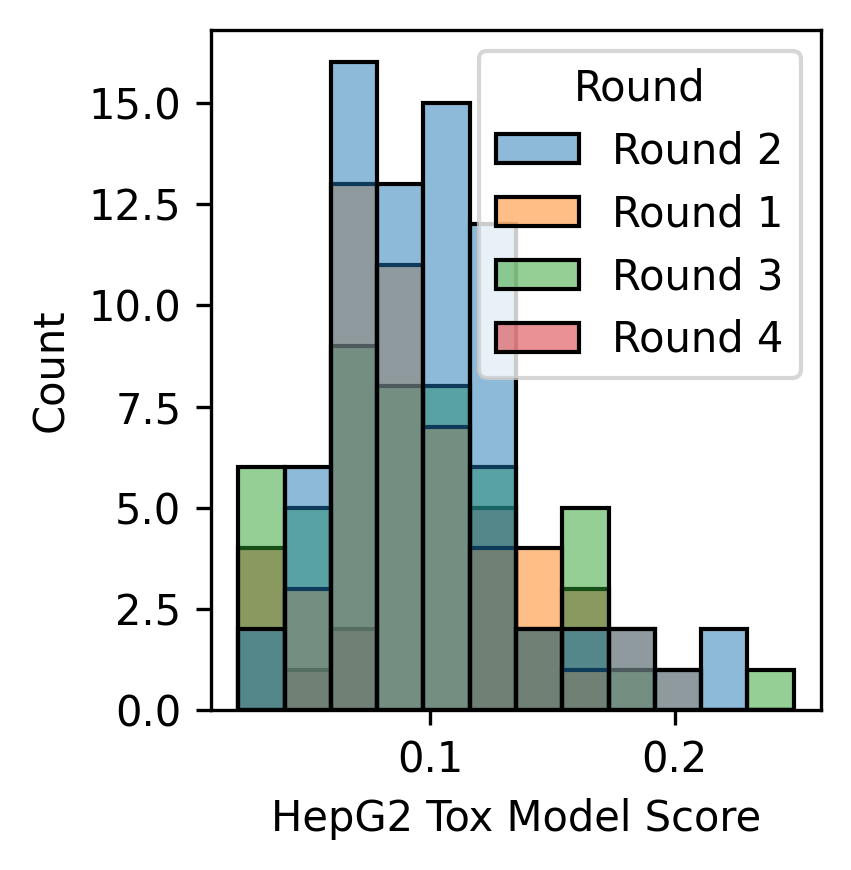

HepG2 pred tox < 0.2:  182


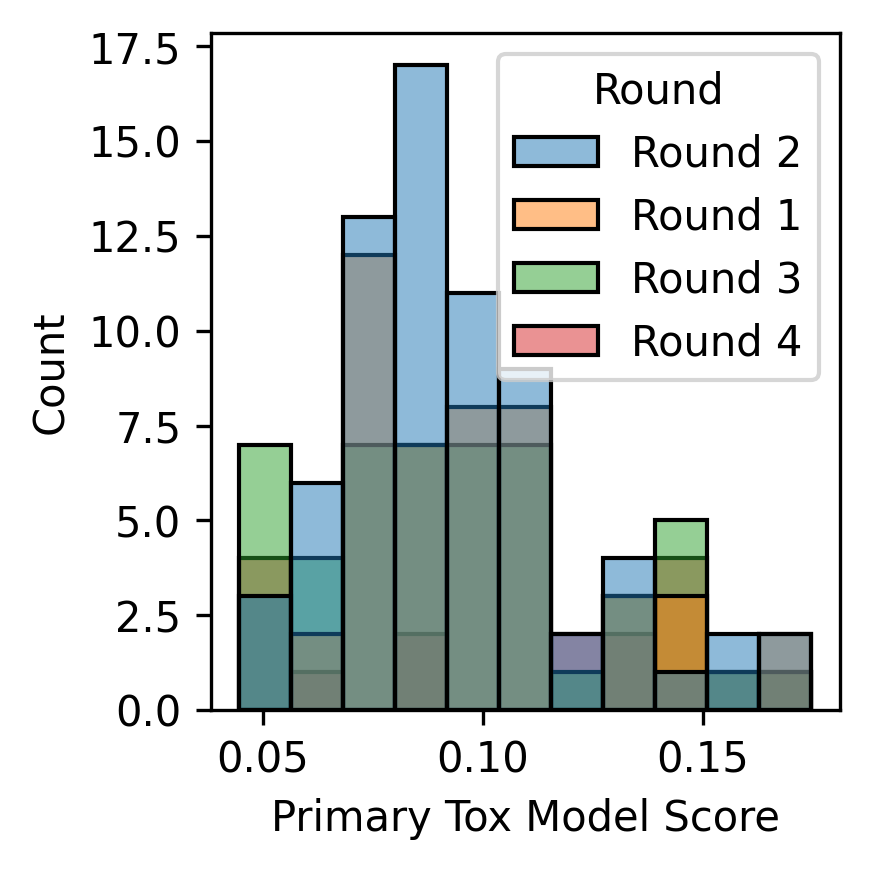

Primary pred tox < 0.2:  182


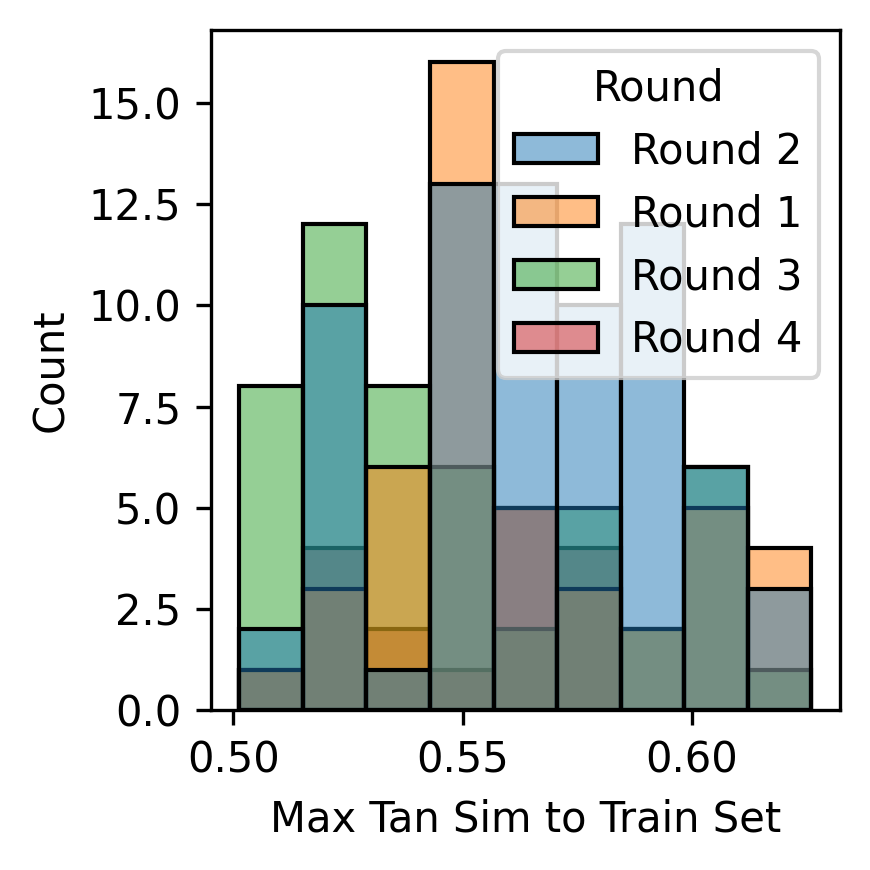

Max Tan Sim to TS < 0.6:  159


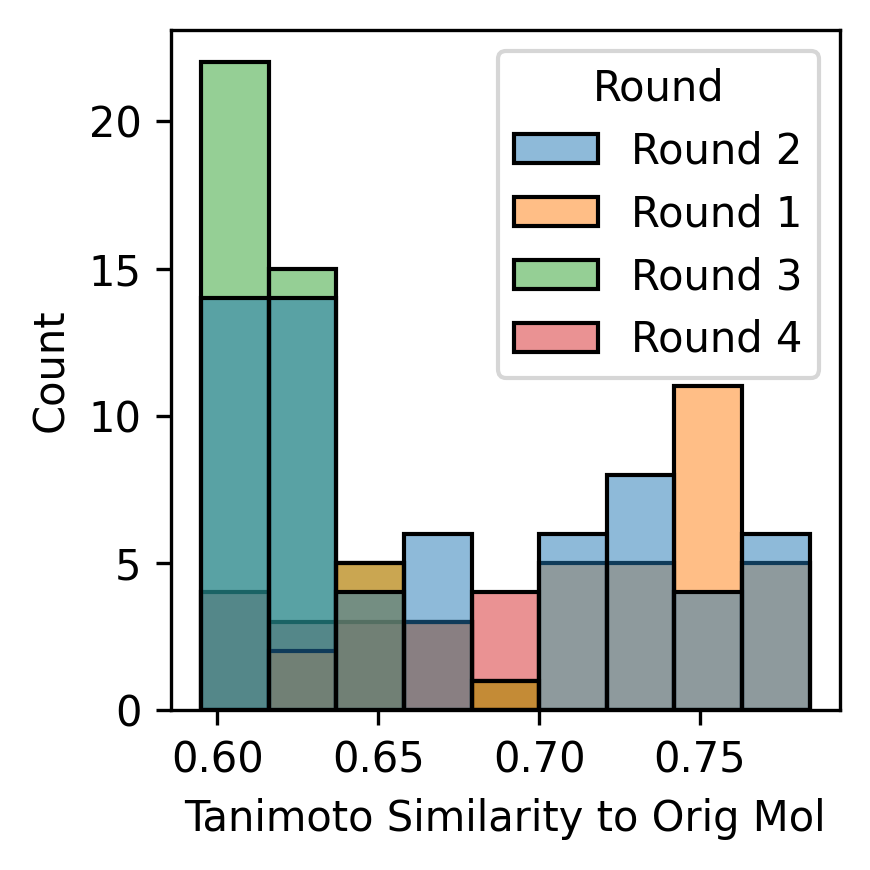

Tan sim to orig mol < 1.0:  159


,Score,Grow_or_Mut,Algorithm_Params,Round,SMILES,ACTIVITY,sa_score,max_tan_sim_to_abx,hepg2_pred_tox,primary_pred_tox,max_tan_sim_to_ts,tan_sim_to_orig_mol
0,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,CSc1c(F)cc(NC(=O)N[C@@H]2[C@@H](OCC(=O)O)[C@@H...,0.552344,4.808337,0.477449,0.094635,0.080388,0.582038,0.624248
1,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,CSc1c(C)cc(NC(=O)N[C@@H]2[C@@H](OCC(=O)O)[C@@H...,0.526111,4.711725,0.486275,0.086844,0.074623,0.595868,0.626943
2,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,C=Cc1cc(NC(=O)N[C@@H]2[C@@H](OCC(=O)O)[C@@H]3C...,0.516418,4.933942,0.495232,0.092952,0.079828,0.593574,0.614167
3,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,CCc1cc(NC(=O)N[C@@H]2[C@@H](OCC(=O)O)[C@@H]3CC...,0.506022,4.769352,0.495818,0.087538,0.073973,0.597780,0.612688
4,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,CSc1c(F)cc(NC(=O)N[C@@H]2[C@@H](OCC(=O)O)[C@@H...,0.547146,4.992847,0.483498,0.113093,0.091290,0.574432,0.615578
...,...,...,...,...,...,...,...,...,...,...,...,...
154,chemprop_score,mutate,0_minsize_4_maxsize_-2_mininc_2_maxinc_2_radius,Round 3,CSc1c(O)cc(NC(=O)N[C@@H]2[C@@H](NC(=O)O)[C@@H]...,0.525940,4.844775,0.455272,0.063918,0.076000,0.532677,0.624348
155,chemprop_score,mutate,0_minsize_4_maxsize_-2_mininc_2_maxinc_2_radius,Round 3,CSc1c(O)cc(NC(=O)N[C@@H]2[C@@H](NC(C)C)[C@@H]3...,0.501804,4.850879,0.454920,0.149708,0.151815,0.545766,0.632133
156,chemprop_score,mutate,0_minsize_4_maxsize_-2_mininc_2_maxinc_2_radius,Round 3,CSc1c(O)cc(NC(=O)N[C@@H]2[C@@H](NCC(=O)O)[C@@H...,0.544601,4.844469,0.464709,0.067496,0.078383,0.548770,0.627383
157,chemprop_score,mutate,0_minsize_4_maxsize_-2_mininc_2_maxinc_2_radius,Round 3,CSc1c(O)cc(NC(=O)N[C@@H]2[C@@H](NCCC(=O)O)[C@@...,0.515752,4.804464,0.461618,0.081048,0.087299,0.553496,0.623591


In [58]:
selectedmolsdf = filter_crem_dataframe(allmolsdf, SMI_COL, HIT_COL, hit_thresh = HIT_THRESH, sascore_thresh = SASCORE_THRESH, tan_to_abx = TAN_TO_ABX, abx_path = ABX_PATH, abx_smiles_col = ABX_SMILES_COL, hepg2_tox_thresh = HEPG2_TOX_THRESH, prim_tox_thresh = PRIM_TOX_THRESH, tan_to_train_set = TAN_TO_TRAIN_SET, train_set_path = TRAIN_SET_PATH, train_set_smiles_col = TRAIN_SET_SMILES_COL, train_set_just_actives = TRAIN_SET_JUST_ACTIVES, orig_mol = ORIG_MOL, orig_mol_tan_thresh = ORIG_MOL_TAN_THRESH, display = DISPLAY_IN_LINE)
display(selectedmolsdf)

In [59]:
analyze_crem_df(selectedmolsdf)
selectedmolsdf.to_csv(OUT_DIR + 'final_crem_mol9_downselected_mols.csv', index = False)

grow 0
mutate 159
regular score 29
modified score 130
round 0 0
round 1 37
round 2 62
round 3 43
round 4 17


# 8M-713

In [60]:
OUT_DIR = '../out/crem/' # intermediate folder for predictions and results, will tag with grow/ or mutate/
RESULTS_PATHS = ['grow', # initial param sweep results
           'mutate', # initial param sweep results
           'v5_more_aggressive_param_sweep_02102023/grow', # expanded
           'v5_more_aggressive_param_sweep_02102023/mutate', # expanded
           'v6_adjusted_directed_score_02102023/grow', # new score
           'v6_adjusted_directed_score_02102023/mutate' # new score
          ]

SMI_COL = 'SMILES'
HIT_COL = 'ACTIVITY'

HIT_THRESH = 0.4
SASCORE_THRESH = 3

TAN_TO_ABX = 0.5
ABX_PATH = '../data/static_datasets/04052022_CLEANED_v5_antibiotics_across_many_classes.csv'
ABX_SMILES_COL = 'Smiles'

HEPG2_TOX_THRESH = 0.2
PRIM_TOX_THRESH = 0.2

TAN_TO_TRAIN_SET = 0.5
TRAIN_SET_PATH = '../data/training_data/SA/combined_SA_screen_39K.csv'
TRAIN_SET_SMILES_COL = 'SMILES'
TRAIN_SET_JUST_ACTIVES = False

ORIG_MOL_SMI = 'CC1=C(C(=O)C=CN1CC2=CC(=CC=C2)Cl)CC3=C(C=CC=C3Cl)Cl'
ORIG_MOL = Chem.MolFromSmiles(ORIG_MOL_SMI)
ORIG_MOL_TAN_THRESH = 1.0

DISPLAY_IN_LINE = True

allmolsdf = collate_crem_molecules_from_multiple_rounds(RESULTS_PATHS, OUT_DIR, smi_col = SMI_COL, hit_col = HIT_COL)
allmolsdf.to_csv(OUT_DIR + '8m_crem/all_crem_8M_generated_mols.csv', index = False)
allmolsdf

original length:  3183069
deduplicated on smiles:  1695243


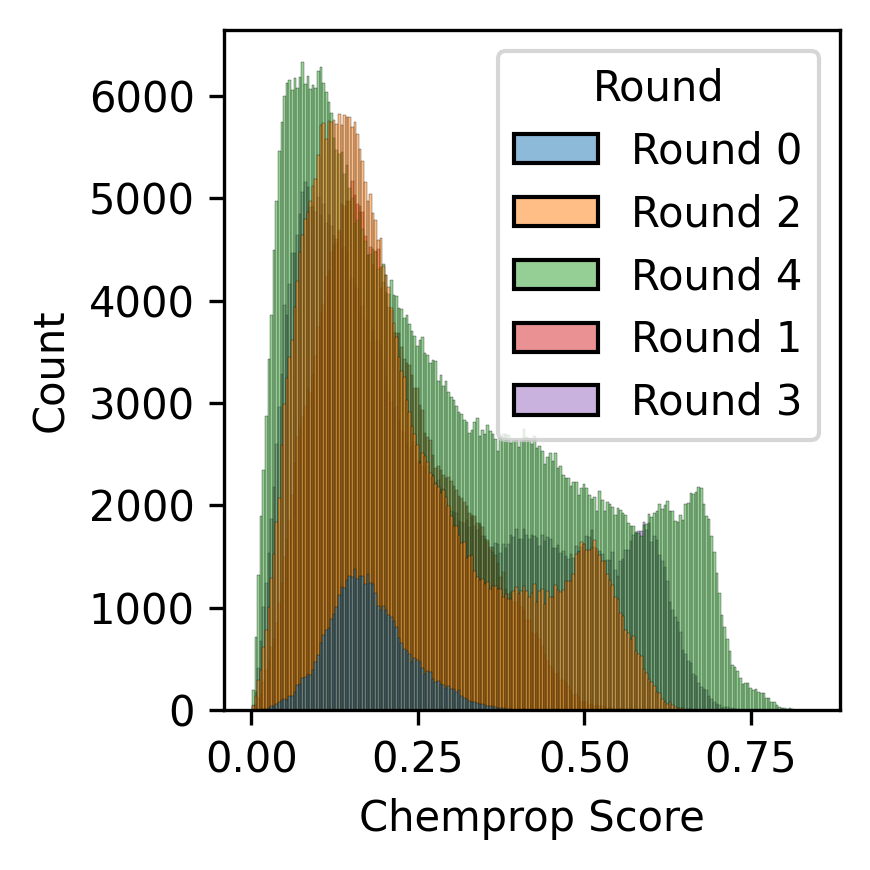

scores > 0.4:  344082


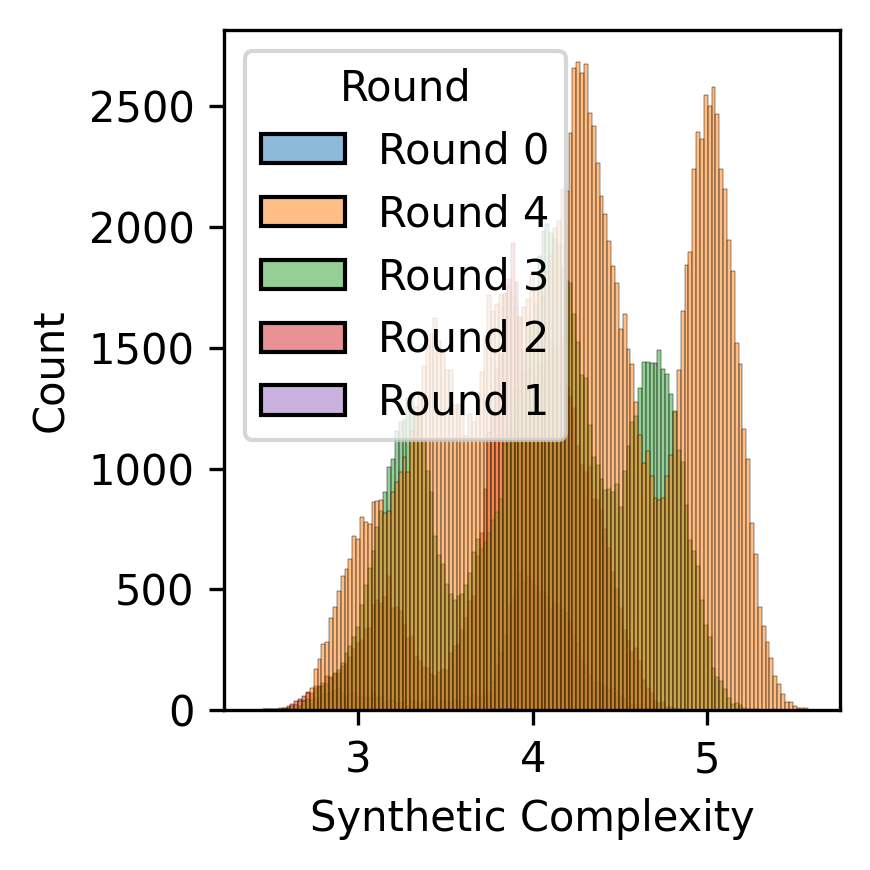

SAScore < 3:  10760


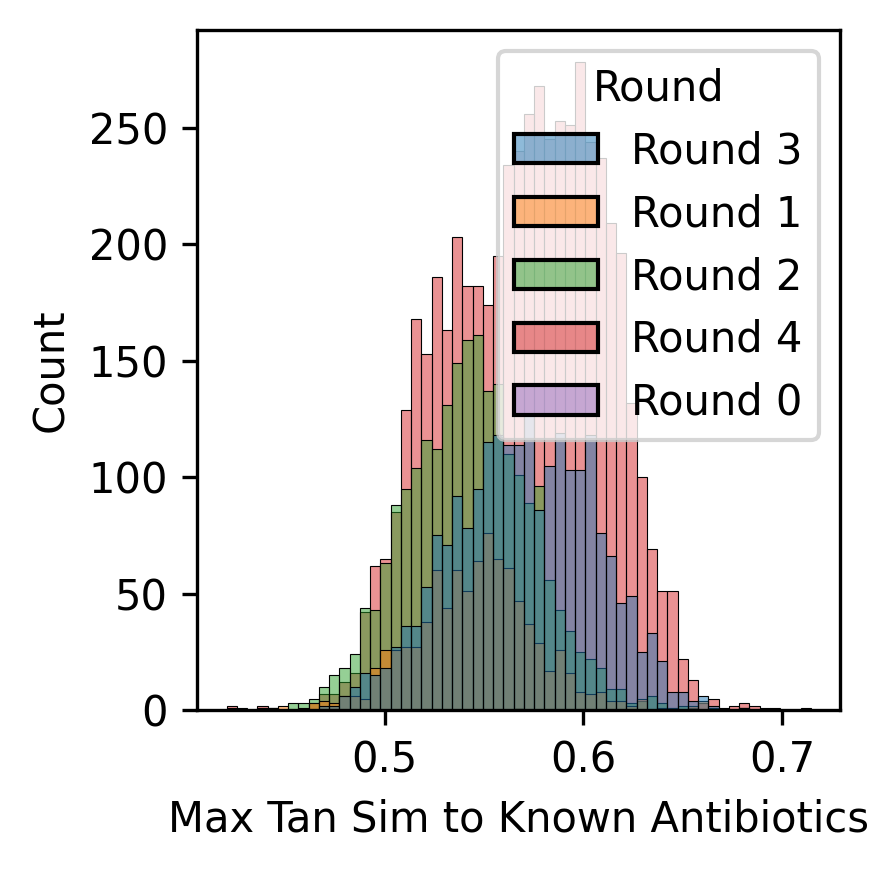

Tan Sim to Abx < 0.5:  486


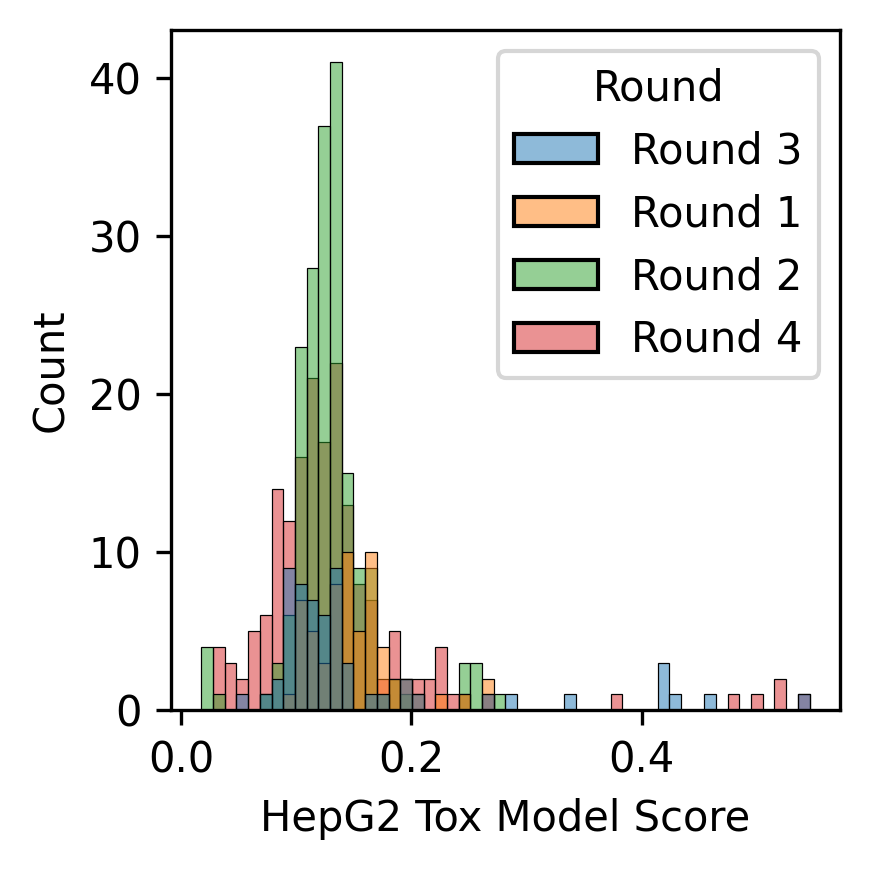

HepG2 pred tox < 0.2:  447


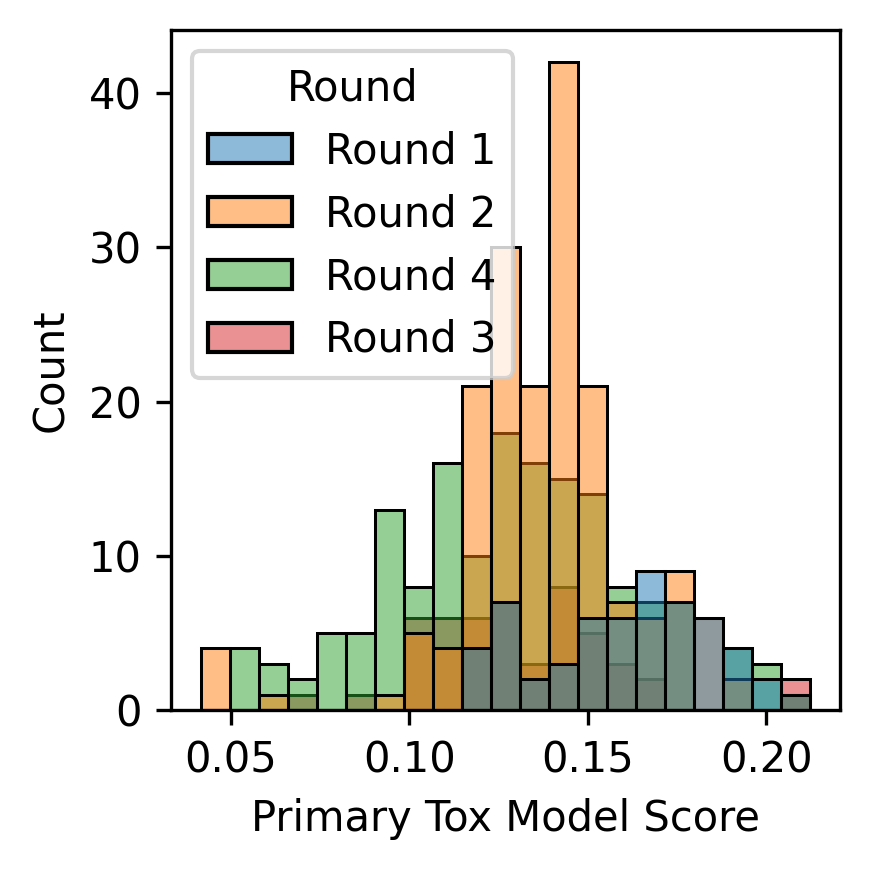

Primary pred tox < 0.2:  439


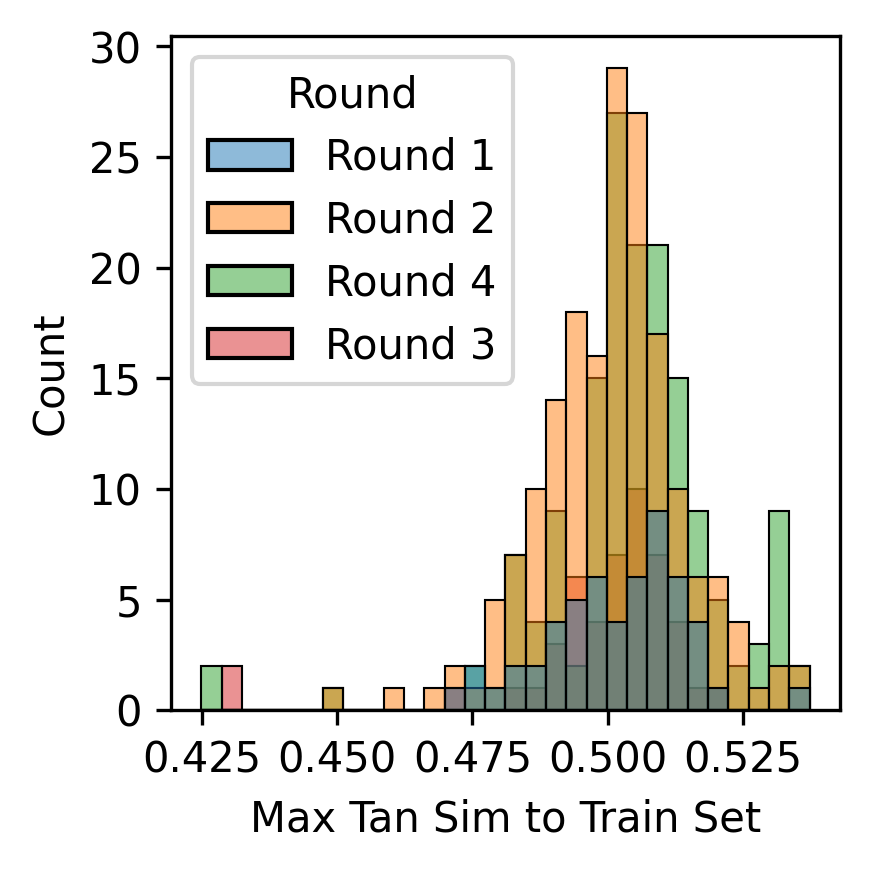

Max Tan Sim to TS < 0.5:  160


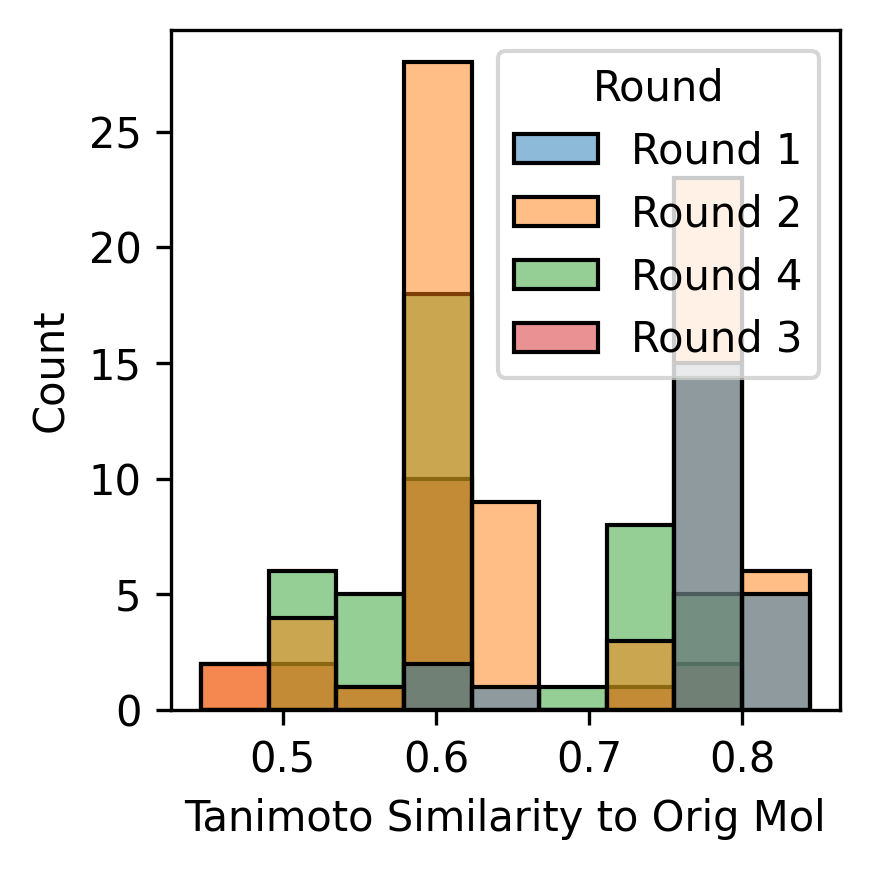

Tan sim to orig mol < 1.0:  160


,Score,Grow_or_Mut,Algorithm_Params,Round,SMILES,ACTIVITY,sa_score,max_tan_sim_to_abx,hepg2_pred_tox,primary_pred_tox,max_tan_sim_to_ts,tan_sim_to_orig_mol
0,chemprop_score,grow,6_maxatom_1_minatom_2_radius,Round 1,CSc1ccc(Cn2ccc(=O)c(Cc3c(Cl)ccc(C(=O)O)c3Cl)c2...,0.402246,2.837700,0.484941,0.123172,0.134278,0.496241,0.775692
1,chemprop_score,grow,6_maxatom_1_minatom_2_radius,Round 1,Cc1c(Cc2c(Cl)ccc(C(=O)O)c2Cl)c(=O)ccn1Cc1ccc(O...,0.424980,2.724610,0.471881,0.133994,0.150534,0.487975,0.799389
2,chemprop_score,grow,6_maxatom_1_minatom_2_radius,Round 1,Cc1c(Cc2c(Cl)ccc(C(=O)O)c2Cl)c(=O)ccn1Cc1cc(O)...,0.422635,2.820353,0.476507,0.107362,0.122460,0.490852,0.789738
3,chemprop_score,grow,6_maxatom_1_minatom_2_radius,Round 1,Cc1c(Cc2c(Cl)cc(O)cc2Cl)c(=O)ccn1Cc1cccc(Cl)c1...,0.418112,2.853374,0.483163,0.103825,0.123348,0.497982,0.777228
4,chemprop_score,grow,4_maxatom_0_minatom_3_radius,Round 2,Cc1cc(C(=O)O)c(Cl)c(Cc2c(C)n(Cc3ccc(O)c(Cl)c3)...,0.425386,2.883821,0.473415,0.136018,0.153685,0.488931,0.796954
...,...,...,...,...,...,...,...,...,...,...,...,...
155,chemprop_score,mutate,0_minsize_6_maxsize_-2_mininc_2_maxinc_2_radius,Round 3,O=C(O)c1cccc(Cl)c1Cc1cn(CSc2ccc(Cl)c(O)c2)ccc1=O,0.476568,2.965450,0.420724,0.123573,0.135518,0.428982,0.498640
156,chemprop_score,mutate,0_minsize_6_maxsize_-2_mininc_2_maxinc_2_radius,Round 3,O=C(O)c1cccc(Cl)c1Cc1c(O)n(CSc2ccc(Cl)c(O)c2)c...,0.459309,2.954746,0.482452,0.107108,0.122781,0.492717,0.482673
157,chemprop_score,mutate,0_minsize_6_maxsize_-2_mininc_2_maxinc_2_radius,Round 3,Cc1c(Cc2c(Cl)cccc2C(=O)O)c(=O)ccn1CCc1ccc(Cl)cc1O,0.412176,2.672639,0.481618,0.101814,0.111646,0.492045,0.596429
158,chemprop_score,mutate,0_minsize_6_maxsize_-2_mininc_2_maxinc_2_radius,Round 3,O=C(O)c1cccc(Cl)c1Cc1cn(CSc2ccc(Cl)cc2O)ccc1=O,0.467481,2.962375,0.427057,0.113223,0.124974,0.431968,0.502254


grow 45
mutate 115
regular score 160
modified score 0
round 0 0
round 1 23
round 2 76
round 3 18
round 4 43


In [62]:
selectedmolsdf = filter_crem_dataframe(allmolsdf, SMI_COL, HIT_COL, hit_thresh = HIT_THRESH, sascore_thresh = SASCORE_THRESH, tan_to_abx = TAN_TO_ABX, abx_path = ABX_PATH, abx_smiles_col = ABX_SMILES_COL, hepg2_tox_thresh = HEPG2_TOX_THRESH, prim_tox_thresh = PRIM_TOX_THRESH, tan_to_train_set = TAN_TO_TRAIN_SET, train_set_path = TRAIN_SET_PATH, train_set_smiles_col = TRAIN_SET_SMILES_COL, train_set_just_actives = TRAIN_SET_JUST_ACTIVES, orig_mol = ORIG_MOL, orig_mol_tan_thresh = ORIG_MOL_TAN_THRESH, display = DISPLAY_IN_LINE)
display(selectedmolsdf)
analyze_crem_df(selectedmolsdf)
selectedmolsdf.to_csv(OUT_DIR + '8m_crem/final_crem_8M_downselected_mols.csv', index = False)

# V027

In [63]:
RESULTS_PATHS = [
           'modified_score/grow', # new score
           'modified_score/mutate', # new score
           'regular_score/grow', # old score
           'regular_score/mutate' # old score
          ] 
OUT_DIR = '../out/crem/v027_crem/' # intermediate folder for predictions and results, will tag with grow/ or mutate/
SMI_COL = 'SMILES'
HIT_COL = 'ACTIVITY'

HIT_THRESH = 0.3
SASCORE_THRESH = 3

TAN_TO_ABX = 0.5
ABX_PATH = '../data/static_datasets/04052022_CLEANED_v5_antibiotics_across_many_classes.csv'
ABX_SMILES_COL = 'Smiles'

HEPG2_TOX_THRESH = 0.2
PRIM_TOX_THRESH = 0.2

TAN_TO_TRAIN_SET = 0.5
TRAIN_SET_PATH = '../data/training_data/SA/combined_SA_screen_39K.csv'
TRAIN_SET_SMILES_COL = 'SMILES'
TRAIN_SET_JUST_ACTIVES = False

betalactam = 'O=C1CCN1'
betalactam_mol = Chem.MolFromSmiles(betalactam)
PATTERNS = [betalactam_mol]

ORIG_MOL_SMI = 'CC1(CNC(=O)CC(c2c[nH]c3ccc(Cl)cc23)c2ccc(Cl)cc2)CCCO1'
ORIG_MOL = Chem.MolFromSmiles(ORIG_MOL_SMI)
ORIG_MOL_TAN_THRESH = 1.0

DISPLAY_IN_LINE = True

allmolsdf = collate_crem_molecules_from_multiple_rounds(RESULTS_PATHS, OUT_DIR, smi_col = SMI_COL, hit_col = HIT_COL)
allmolsdf.to_csv(OUT_DIR + 'all_crem_v027_generated_mols.csv', index = False)
allmolsdf

,Score,Grow_or_Mut,Algorithm_Params,Round,SMILES,ACTIVITY
0,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,CC1(CNC(=O)CC(c2cc(SC3CC(=O)N3)c(Cl)cc2Br)c2c[...,0.565639
1,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,CC1(CNC(=O)CC(c2cc(SC3CC(=O)N3)c(Cl)cc2SCc2cc(...,0.548289
2,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,CC1(CNC(=O)CC(c2cc(SC3CC(=O)N3)c(Cl)cc2Nc2cc(B...,0.514593
3,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,CC1(CNC(=O)CC(c2cc(SC3CC(=O)N3)c(Cl)cc2-c2ccc(...,0.526683
4,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,CC1(CNC(=O)CC(c2cc(SC3CC(=O)N3)c(Cl)cc2-c2cccc...,0.521486
...,...,...,...,...,...,...
2428,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,CCCn1cc(C(COC(=O)c2cc(C)ccc2C)c2ccc(Cl)cc2)c2c...,0.191367
2429,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,CCCCn1cc(C(COC(=O)c2cc(C)ccc2C)c2ccc(Cl)cc2)c2...,0.196662
2430,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,COCCn1cc(C(COC(=O)c2cc(C)ccc2C)c2ccc(Cl)cc2)c2...,0.166428
2431,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,Cc1ccc(C)c(C(=O)OCC(c2ccc(Cl)cc2)c2cn(CCO)c3cc...,0.130021


original length:  1062567
deduplicated on smiles:  829142


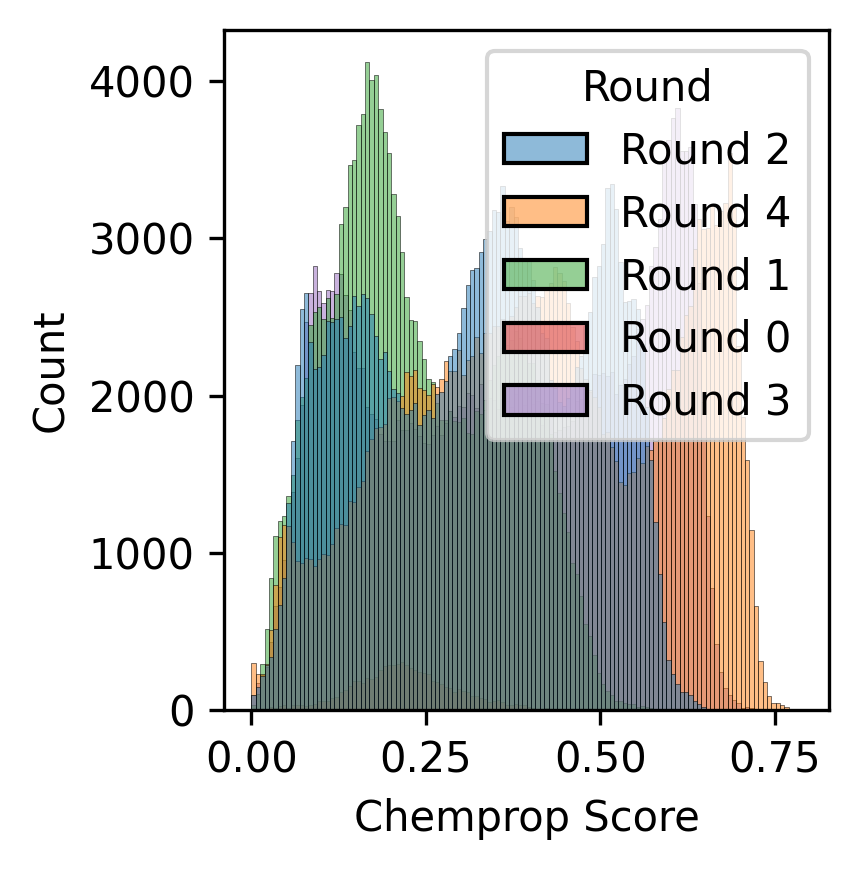

scores > 0.3:  464719


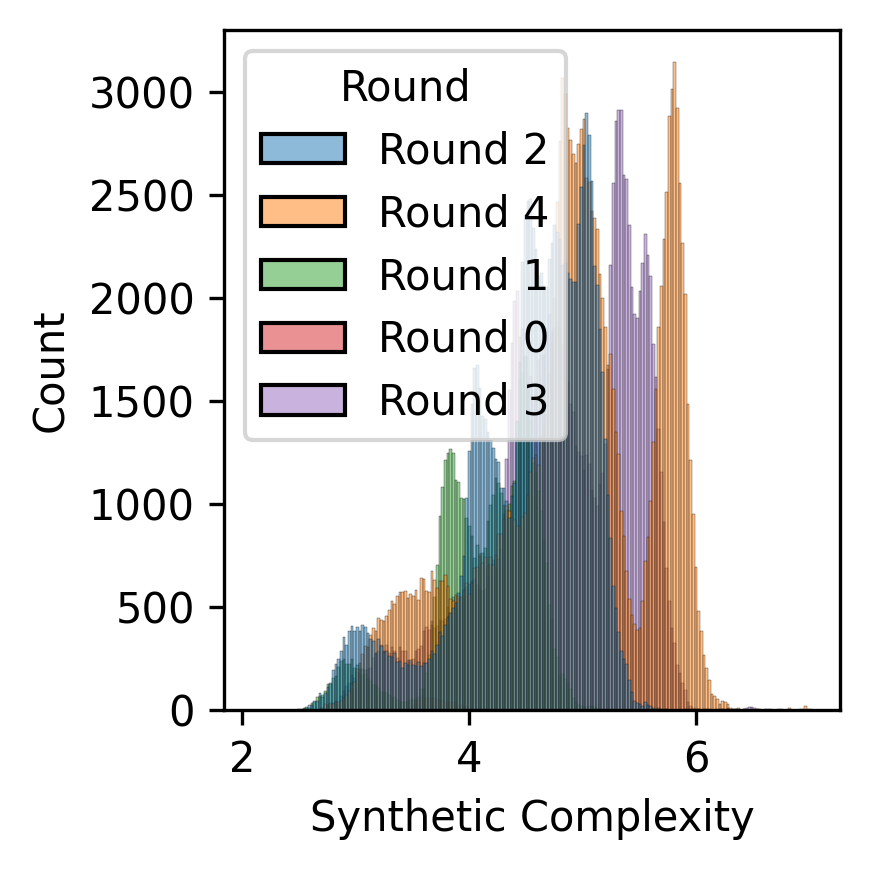

SAScore < 3:  7571


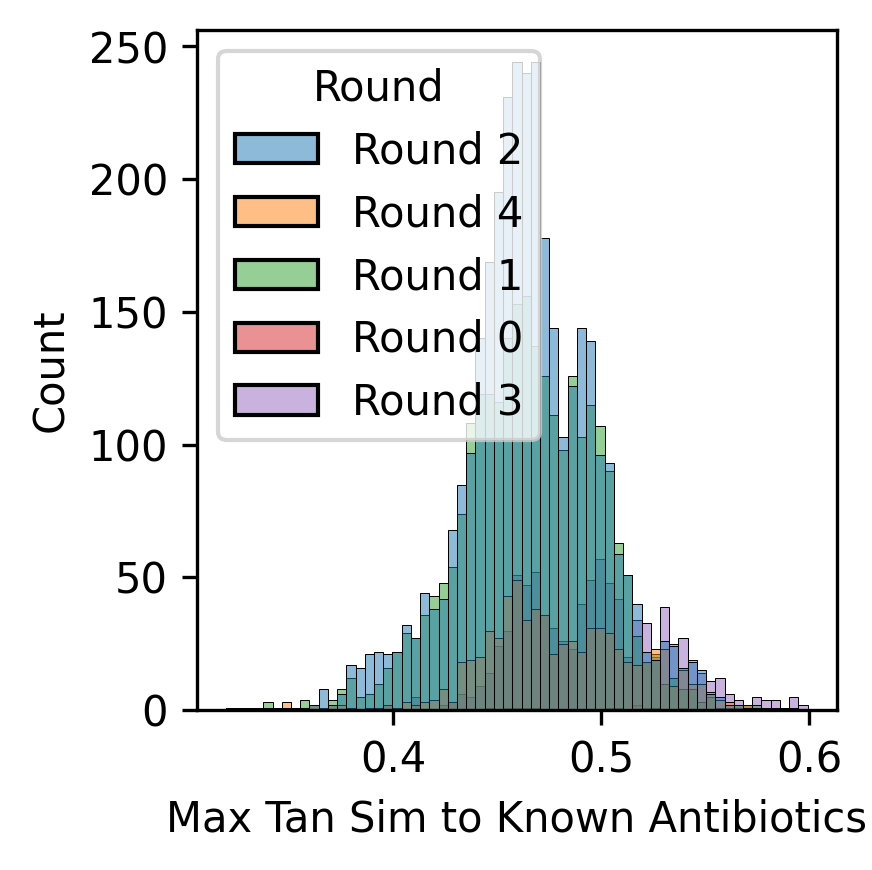

Tan Sim to Abx < 0.5:  6143


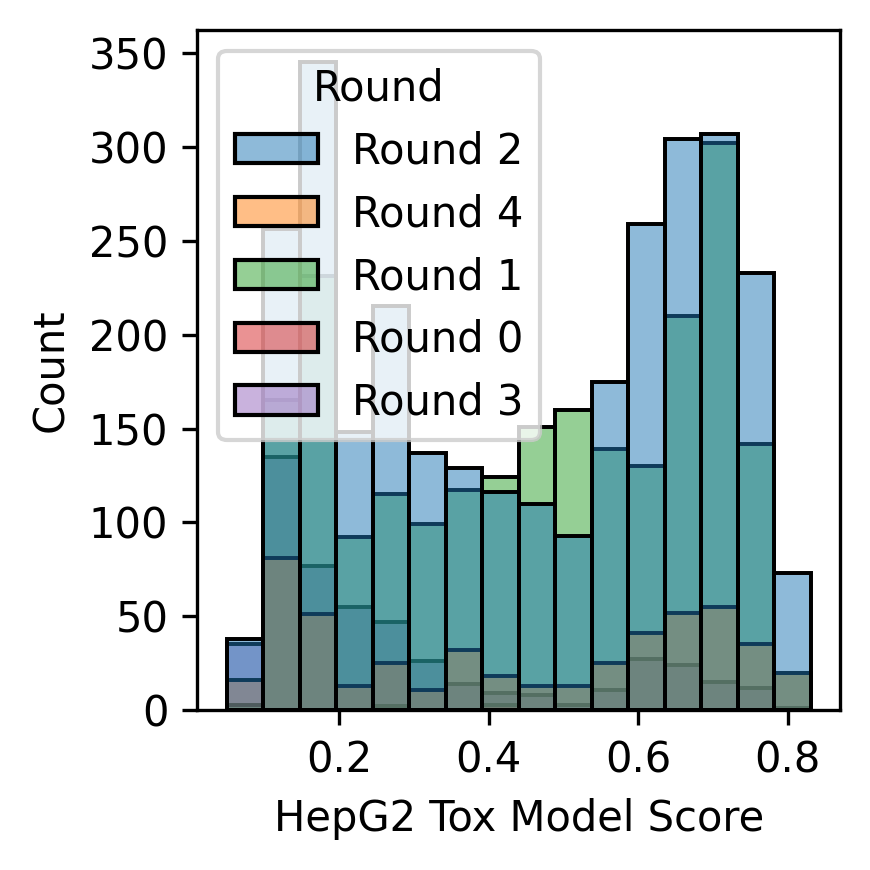

HepG2 pred tox < 0.2:  1465


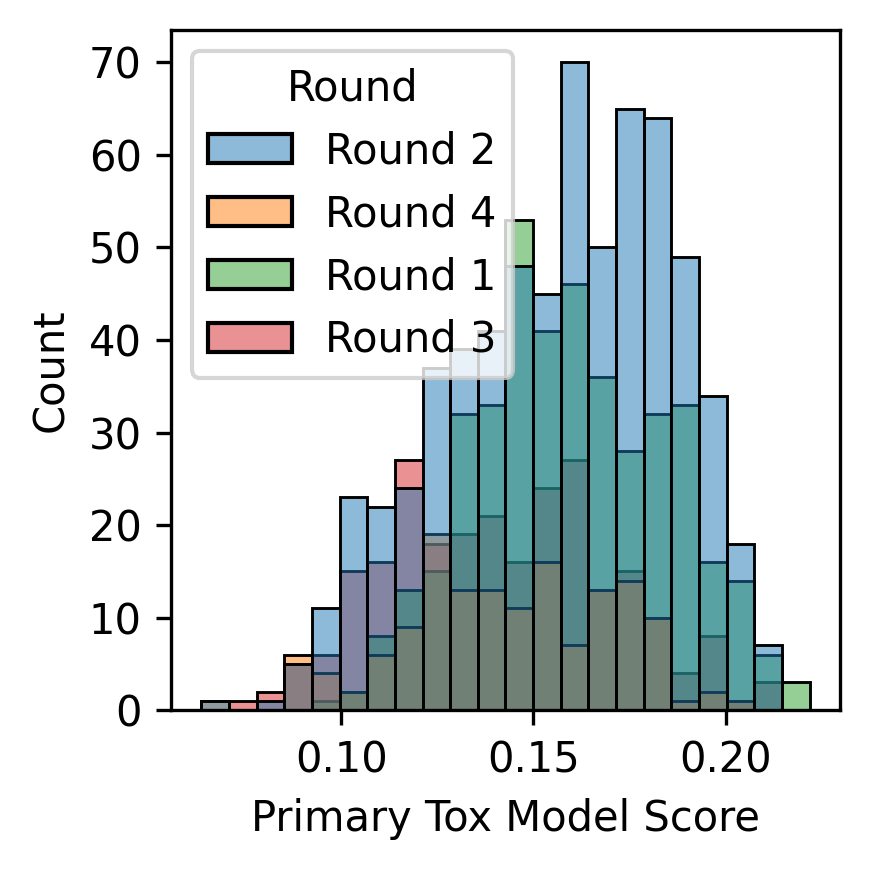

Primary pred tox < 0.2:  1410


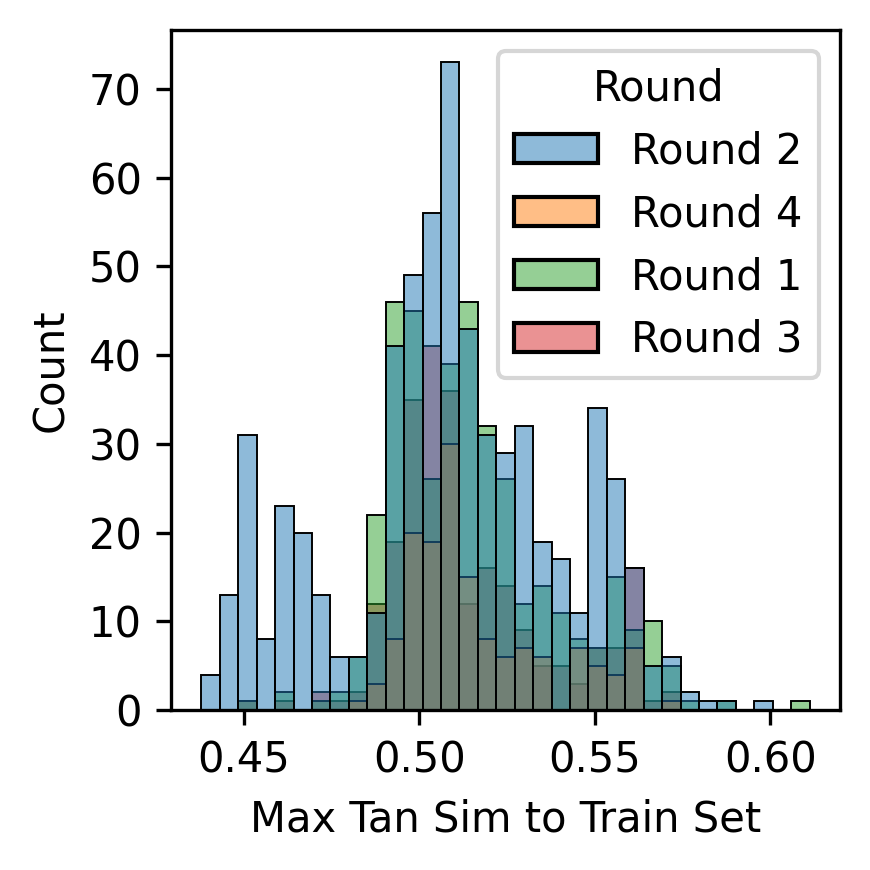

Max Tan Sim to TS < 0.5:  428
excluding pattern:  428


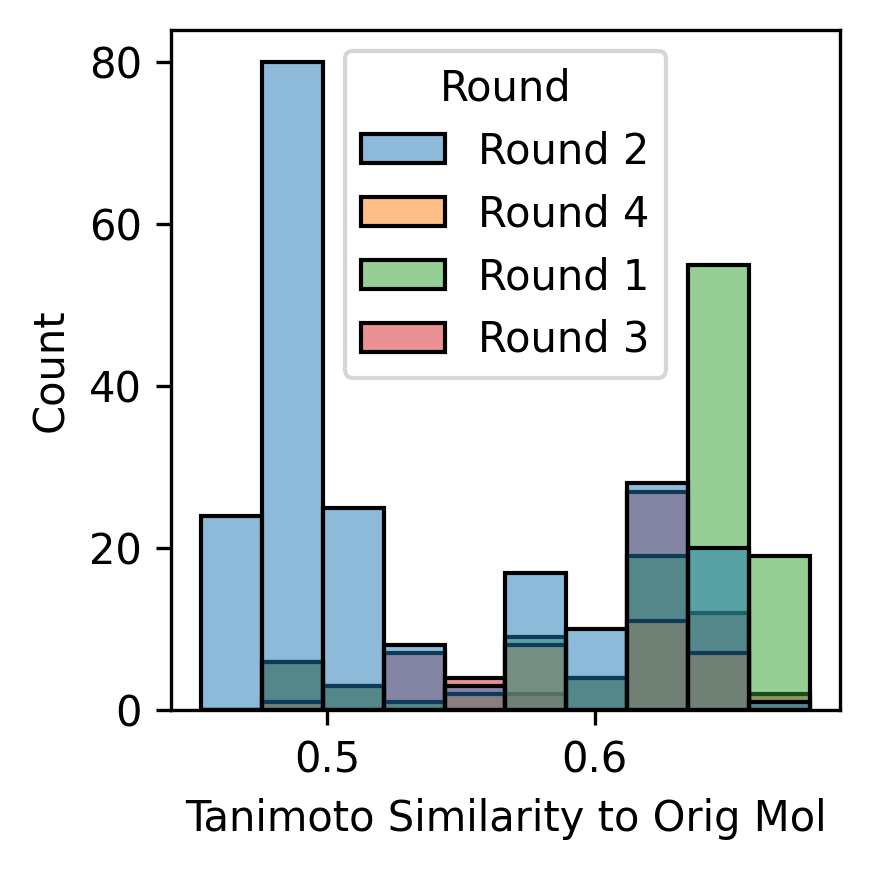

Tan sim to orig mol < 1.0:  428


,Score,Grow_or_Mut,Algorithm_Params,Round,SMILES,ACTIVITY,sa_score,max_tan_sim_to_abx,hepg2_pred_tox,primary_pred_tox,max_tan_sim_to_ts,tan_sim_to_orig_mol
0,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,Cc1cc(C(Cc2ccccc2)c2c[nH]c3ccc(Cl)cc23)cc(C(=O...,0.354860,2.786506,0.468346,0.169930,0.176326,0.493103,0.569707
1,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,Cc1cc(C(CCc2ccccc2)c2c[nH]c3ccc(Cl)cc23)cc(C(=...,0.359389,2.823845,0.461200,0.176081,0.182976,0.497824,0.624552
2,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,Cc1cc(C(CC(C)C)c2c[nH]c3ccc(Cl)cc23)cc(C(=O)O)c1O,0.380088,2.952035,0.462046,0.160541,0.165244,0.491349,0.634563
3,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,CCCCC(c1cc(C)c(O)c(C(=O)O)c1)c1c[nH]c2ccc(Cl)cc12,0.390110,2.879223,0.462534,0.156648,0.162366,0.493495,0.634234
4,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,COc1ccc(CC(c2cc(C)c(O)c(C(=O)O)c2)c2c[nH]c3ccc...,0.354046,2.839157,0.477582,0.178460,0.186156,0.491901,0.568995
...,...,...,...,...,...,...,...,...,...,...,...,...
423,chemprop_score,mutate,0_minsize_8_maxsize_-2_mininc_2_maxinc_3_radius,Round 4,O=C(O)c1ccc(C(=O)OCC(c2ccc(Cl)cc2)c2c[nH]c3c(F...,0.305877,2.894659,0.458061,0.120473,0.134491,0.485934,0.567037
424,chemprop_score,mutate,0_minsize_8_maxsize_-2_mininc_2_maxinc_3_radius,Round 4,O=C(O)c1cccc(C(=O)OCC(c2ccc(Cl)cc2)c2c[nH]c3c(...,0.309144,2.939329,0.473310,0.116423,0.134497,0.486860,0.564489
425,chemprop_score,mutate,0_minsize_8_maxsize_-2_mininc_2_maxinc_3_radius,Round 4,O=C(O)c1ccccc1C(=O)OCC(c1ccc(Cl)cc1)c1c[nH]c2c...,0.313068,2.942165,0.484570,0.169697,0.183196,0.494978,0.568951
426,chemprop_score,mutate,0_minsize_8_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,O=C(O)c1ccc(COCC(c2ccc(Cl)cc2)c2c[nH]c3c(F)cc(...,0.332407,2.890077,0.451832,0.168843,0.175916,0.487424,0.574042


grow 0
mutate 428
regular score 25
modified score 403
round 0 0
round 1 116
round 2 216
round 3 67
round 4 29


In [64]:
selectedmolsdf = filter_crem_dataframe(allmolsdf, SMI_COL, HIT_COL, hit_thresh = HIT_THRESH, sascore_thresh = SASCORE_THRESH, tan_to_abx = TAN_TO_ABX, abx_path = ABX_PATH, abx_smiles_col = ABX_SMILES_COL, hepg2_tox_thresh = HEPG2_TOX_THRESH, prim_tox_thresh = PRIM_TOX_THRESH, tan_to_train_set = TAN_TO_TRAIN_SET, train_set_path = TRAIN_SET_PATH, train_set_smiles_col = TRAIN_SET_SMILES_COL, train_set_just_actives = TRAIN_SET_JUST_ACTIVES, orig_mol = ORIG_MOL, orig_mol_tan_thresh = ORIG_MOL_TAN_THRESH, patterns = PATTERNS, display = DISPLAY_IN_LINE)
display(selectedmolsdf)
analyze_crem_df(selectedmolsdf)
selectedmolsdf.to_csv(OUT_DIR + 'final_crem_v027_downselected_mols.csv', index = False)

# NG Cpd

In [66]:
RESULTS_PATHS = [ # intermediate folder for predictions and results, will tag with grow/ or mutate/
           'modified_score/grow', # new score
           'modified_score/mutate', # new score
           'regular_score/grow', # old score
           'regular_score/mutate' # old score
          ] 
OUT_DIR = '../out/crem/ng_crem/'

SMI_COL = 'SMILES'
HIT_COL = 'hit'

HIT_THRESH = 0.7
SASCORE_THRESH = 3

TAN_TO_ABX = 0.5
ABX_PATH = '../data/static_datasets/04052022_CLEANED_v5_antibiotics_across_many_classes.csv'
ABX_SMILES_COL = 'Smiles'

HEPG2_TOX_THRESH = 0.2
PRIM_TOX_THRESH = 0.2

TAN_TO_TRAIN_SET = 0.5
TRAIN_SET_PATH = '../data/training_data/SA/combined_SA_screen_39K.csv'
TRAIN_SET_SMILES_COL = 'SMILES'
TRAIN_SET_JUST_ACTIVES = False

betalactam = 'O=C1CCN1'
betalactam_mol = Chem.MolFromSmiles(betalactam)
PATTERNS = [betalactam_mol]

ORIG_MOL_SMI = 'Clc1ccc(c(c1)Cl)N1CC[C@@H](C1)NC(=O)c1cn[nH]n1'
ORIG_MOL = Chem.MolFromSmiles(ORIG_MOL_SMI)
ORIG_MOL_TAN_THRESH = 1.0
DISPLAY_IN_LINE = True

allmolsdf = collate_crem_molecules_from_multiple_rounds(RESULTS_PATHS, OUT_DIR, smi_col = SMI_COL, hit_col = HIT_COL)
allmolsdf.to_csv(OUT_DIR + 'all_crem_ngcpd_generated_mols.csv', index = False)
allmolsdf

,Score,Grow_or_Mut,Algorithm_Params,Round,SMILES,hit
0,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,O=C1CC(Sc2cc(N3CC[C@H](NC(=O)c4n[nH]nc4C(=O)OC...,0.676424
1,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,O=C1CC(Sc2cc(N3CC[C@H](NC(=O)c4n[nH]nc4C(=O)OC...,0.661152
2,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,O=C1CC(Sc2cc(N3CC[C@H](NC(=O)c4n[nH]nc4C(=O)OC...,0.656603
3,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,O=C1CC(Sc2cc(N3CC[C@H](NC(=O)c4n[nH]nc4C(=O)OC...,0.690478
4,modified_score,grow,10_maxatom_0_minatom_2_radius,Round 2,O=C1CC(Sc2cc(N3CC[C@H](NC(=O)c4n[nH]nc4C(=O)Oc...,0.782609
...,...,...,...,...,...,...
1294,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,O=C(Cc1ccc(O)cc1Cl)N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1,0.559532
1295,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,COc1cc(O)ccc1CC(=O)N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1,0.457275
1296,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,O=C(Cc1ccc(O)cc1F)N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1,0.495008
1297,chemprop_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,N#Cc1cc(O)ccc1CC(=O)N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1,0.464079


original length:  518203
deduplicated on smiles:  423095


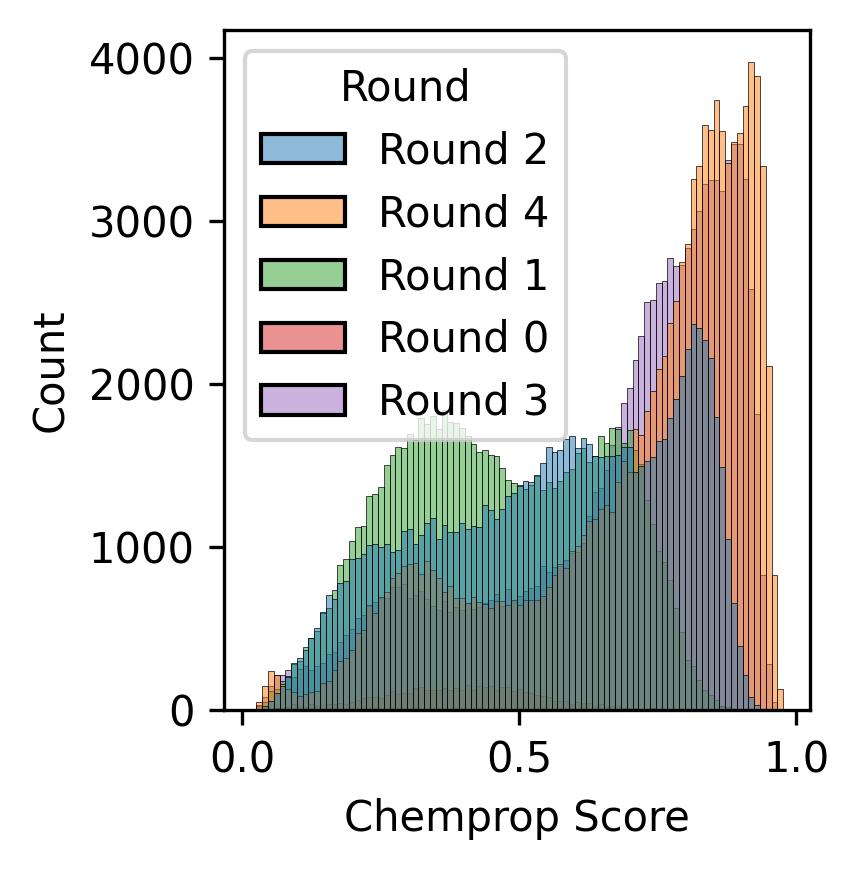

scores > 0.7:  180827


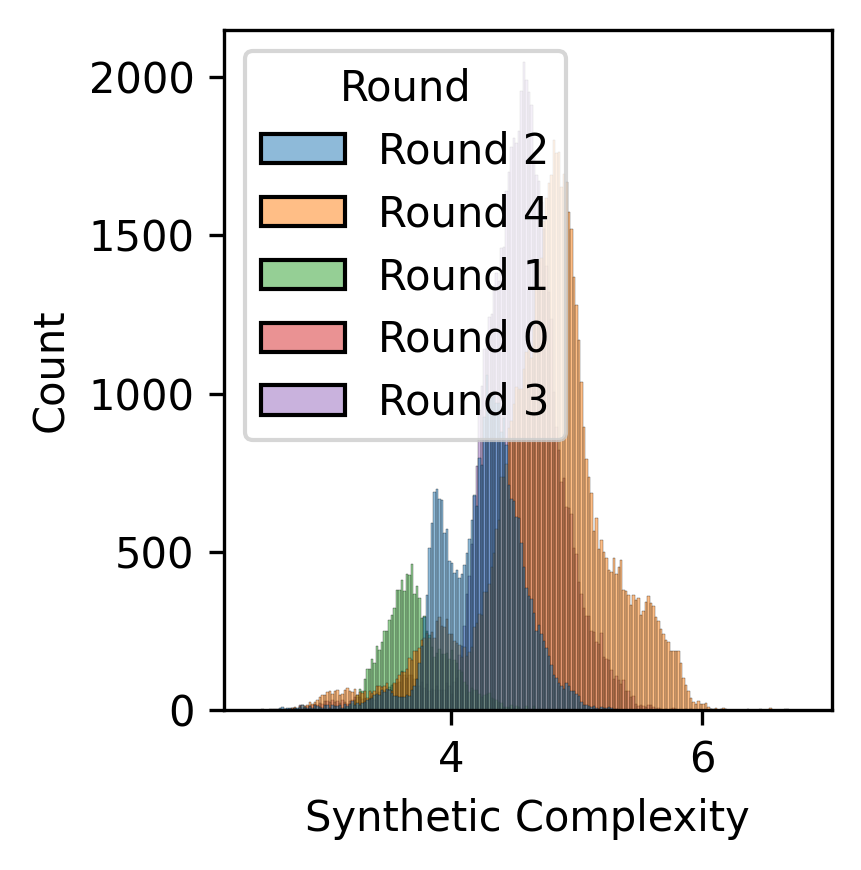

SAScore < 3:  763


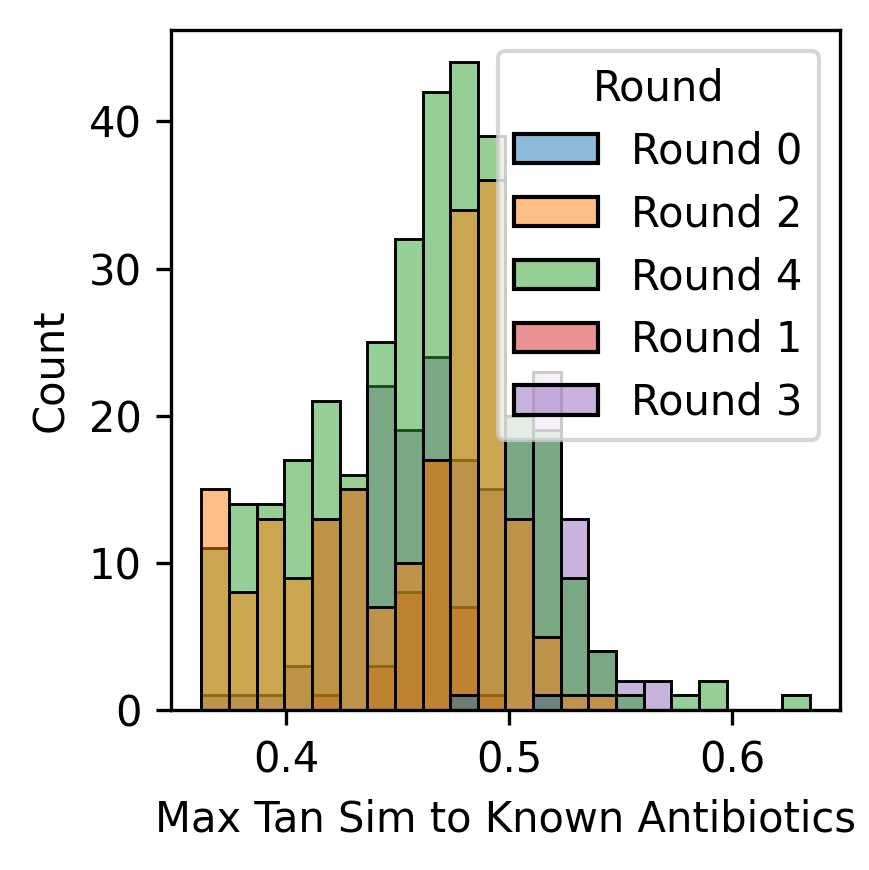

Tan Sim to Abx < 0.5:  627


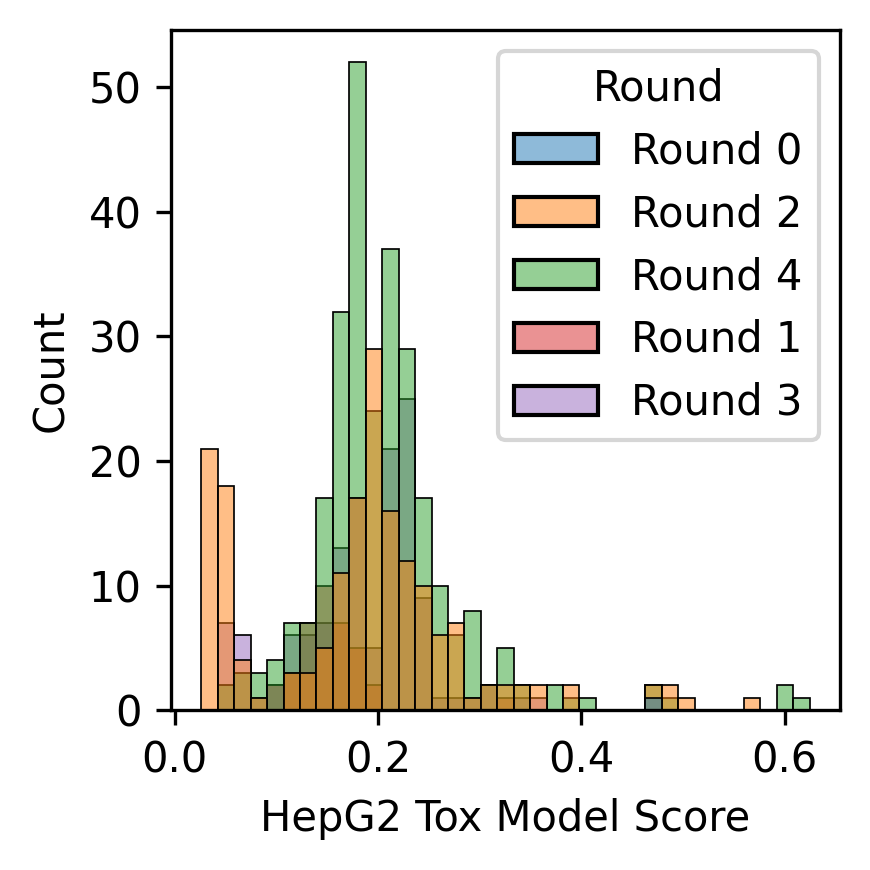

HepG2 pred tox < 0.2:  357


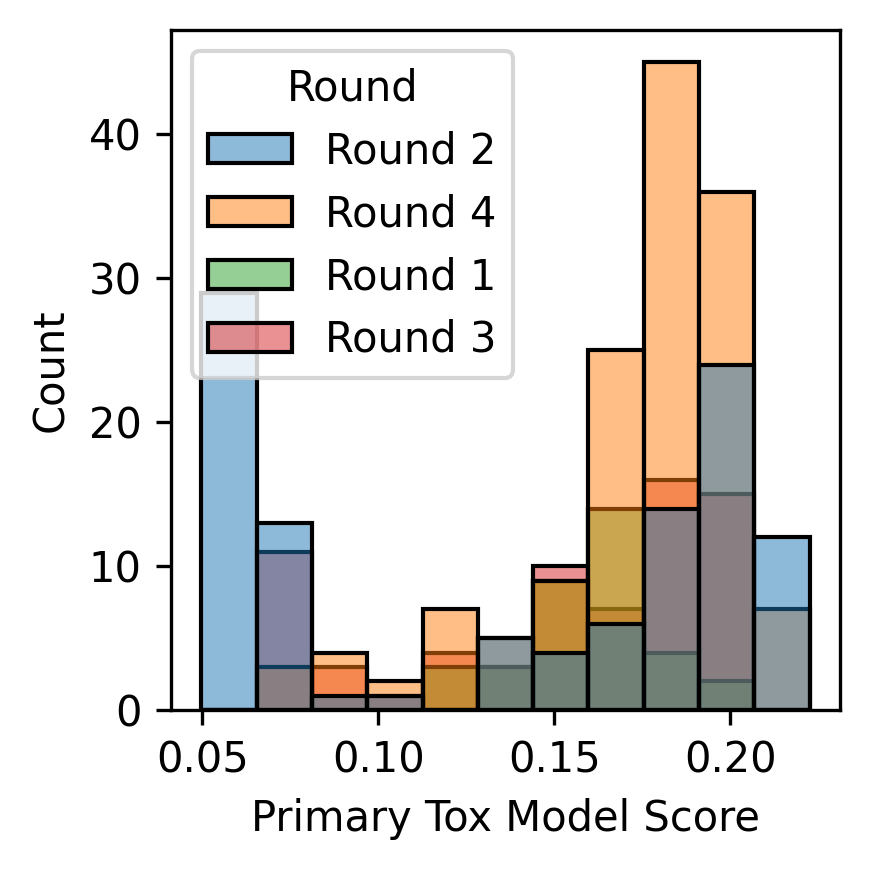

Primary pred tox < 0.2:  318


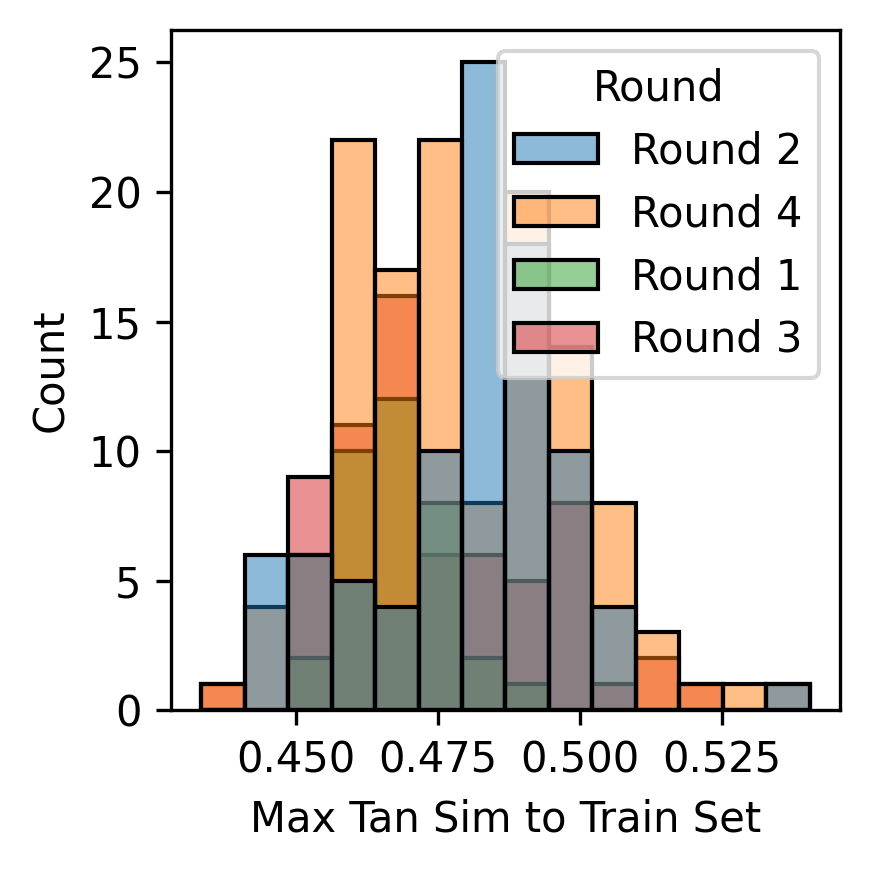

Max Tan Sim to TS < 0.5:  285
excluding pattern:  285


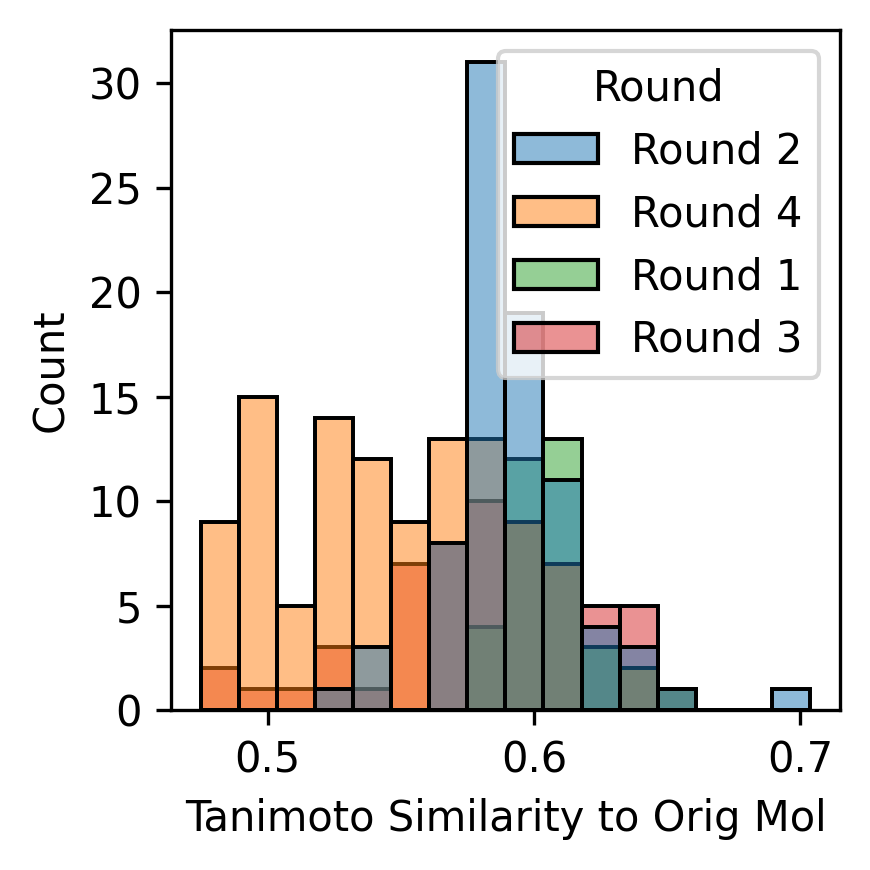

Tan sim to orig mol < 1.0:  285


,Score,Grow_or_Mut,Algorithm_Params,Round,SMILES,hit,sa_score,max_tan_sim_to_abx,hepg2_pred_tox,primary_pred_tox,max_tan_sim_to_ts,tan_sim_to_orig_mol
0,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,O=C(N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1)c1ncccc1Cl,0.701781,2.580029,0.436454,0.122280,0.143661,0.453462,0.656489
1,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,Cc1cc(C(=O)N[C@H]2CCN(c3ccc(Cl)cc3Cl)C2)c(Cl)c...,0.713328,2.568358,0.393337,0.185854,0.199496,0.441355,0.619469
2,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,O=C(N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1)c1cccc(Cl)c1Cl,0.746292,2.498822,0.393107,0.184862,0.198658,0.447323,0.609890
3,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,O=C(N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1)c1ccc(Cl)cc1Cl,0.708204,2.432047,0.375736,0.182174,0.193384,0.443548,0.636994
4,modified_score,mutate,0_minsize_10_maxsize_-2_mininc_2_maxinc_2_radius,Round 2,O=C(CSc1cccc(Cl)c1Cl)N[C@H]1CCN(c2ccc(Cl)cc2Cl)C1,0.720584,2.720084,0.370690,0.195645,0.197246,0.474002,0.539804
...,...,...,...,...,...,...,...,...,...,...,...,...
280,chemprop_score,mutate,0_minsize_6_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,CNC(=O)c1cc(Cl)c(Cl)c(C(=O)N[C@H]2CCN(c3ccc(Cl...,0.710925,2.757445,0.421235,0.180466,0.178091,0.449587,0.582564
281,chemprop_score,mutate,0_minsize_6_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,CS(=O)(=O)c1cc(Cl)c(Cl)c(C(=O)N[C@H]2CCN(c3ccc...,0.704146,2.788995,0.489493,0.162548,0.183529,0.496923,0.508850
282,chemprop_score,mutate,0_minsize_6_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,NC(=O)c1cc(Cl)c(Cl)c(C(=O)N[C@H]2CCN(c3ccc(Cl)...,0.742038,2.752907,0.420901,0.186763,0.196059,0.449132,0.582136
283,chemprop_score,mutate,0_minsize_6_maxsize_-2_mininc_2_maxinc_3_radius,Round 3,O=C(O)c1cc(Cl)c(Cl)c(C(=O)N[C@H]2CCN(c3ccc(Cl)...,0.793855,2.710600,0.446039,0.097094,0.110858,0.466864,0.556962


grow 0
mutate 285
regular score 132
modified score 153
round 0 0
round 1 35
round 2 82
round 3 60
round 4 108


In [67]:
selectedmolsdf = filter_crem_dataframe(allmolsdf, SMI_COL, HIT_COL, hit_thresh = HIT_THRESH, sascore_thresh = SASCORE_THRESH, tan_to_abx = TAN_TO_ABX, abx_path = ABX_PATH, abx_smiles_col = ABX_SMILES_COL, hepg2_tox_thresh = HEPG2_TOX_THRESH, prim_tox_thresh = PRIM_TOX_THRESH, tan_to_train_set = TAN_TO_TRAIN_SET, train_set_path = TRAIN_SET_PATH, train_set_smiles_col = TRAIN_SET_SMILES_COL, train_set_just_actives = TRAIN_SET_JUST_ACTIVES, orig_mol = ORIG_MOL, orig_mol_tan_thresh = ORIG_MOL_TAN_THRESH, patterns = PATTERNS, display = DISPLAY_IN_LINE)
display(selectedmolsdf)
analyze_crem_df(selectedmolsdf)
selectedmolsdf.to_csv(OUT_DIR + 'final_crem_ngcpd_downselected_mols.csv', index = False)